In [43]:
from copy import deepcopy as dc
import pandas as pd


def prepare_dataframe_for_lstm(df, n_steps):
    df['Date'] = pd.to_datetime(df['Date'])
    df = dc(df)
    df.set_index('Date', inplace=True)
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data[['Date', 'Close']], lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2014-01-10,215.066666,210.399994,211.233337,211.133331,210.433334,209.833328,209.966660,214.933334
2014-01-13,216.966660,215.066666,210.399994,211.233337,211.133331,210.433334,209.833328,209.966660
2014-01-14,216.300003,216.966660,215.066666,210.399994,211.233337,211.133331,210.433334,209.833328
2014-01-15,219.233337,216.300003,216.966660,215.066666,210.399994,211.233337,211.133331,210.433334
2014-01-16,217.000000,219.233337,216.300003,216.966660,215.066666,210.399994,211.233337,211.133331
...,...,...,...,...,...,...,...,...
2023-12-22,455.200012,451.450012,451.000000,456.100006,451.649994,458.200012,460.100006,455.649994
2023-12-26,456.450012,455.200012,451.450012,451.000000,456.100006,451.649994,458.200012,460.100006
2023-12-27,457.100006,456.450012,455.200012,451.450012,451.000000,456.100006,451.649994,458.200012


convert dataframe to numpy ---> use MinMaxScaler(feature_range=(-1,1))

    (2458, 8)
    [-0.60674592 -0.63380693 -0.62897455 -0.62955447 -0.6336136  -0.6370929
    -0.63631974 -0.60751907]

X : (Number of Samples, Time Steps)

Y : (Number of Samples, )

now flip X along axis=1 (columns) just to change the order of values ---> do train-test split but before that reshape it to (:,-1,1) & (:,1)

X_train,X_test : (Number of Samples, Time Steps, Features)

y_train,y_test : (Number of Samples, Features)


    class TimeSeriesDataset(Dataset):
          def __init__(self, X, y):
              self.X = X
              self.y = y

          def __len__(self):
              return len(self.X)

          def __getitem__(self, i):
              return self.X[i], self.y[i]

          @property
          def shape(self):
              return self.X.shape


    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)

    len - 2335
    getitem - (tensor([[-0.6075],
            [-0.6363],
            [-0.6371],
            [-0.6336],
            [-0.6296],
            [-0.6290],
            [-0.6338]]), tensor([-0.6067]))
    torch.Size([Time step, 1]) torch.Size([1])

use DataLoader to put into batch

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    Train dataset shape(train_loader.dataset.shape): torch.Size([2335, 7, 1])

    Test dataset shape: torch.Size([123, 7, 1])


    for idx, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        print(x_batch.shape, y_batch.shape)
        break

    torch.Size([16, 7, 1]) torch.Size([16, 1])

1. **Why do the three LSTM layers have the same dimensions?**

The three LSTM layers (`self.lstm1`, `self.lstm2`, and `self.lstm3`) have the same output dimensions (`batch_size, sequence_length, hidden_size`) because they are stacked on top of each other. In this architecture, the output of one LSTM layer is fed as input to the next LSTM layer. Since the hidden state size (`hidden_size`) remains the same across all layers, the output dimensions stay consistent.

2. **What is the significance of `num_stacked_layers`?**

The `num_stacked_layers` parameter in the LSTM layers determines the number of LSTM cells that are vertically stacked. Each LSTM cell processes the input sequence and passes its output (hidden state and cell state) to the next LSTM cell in the stack. This allows the model to learn more complex representations by capturing long-term dependencies in the input sequence.

In the provided code, `num_stacked_layers` is set to 2, which means there are two LSTM cells stacked on top of each other in each of the three LSTM layers (`self.lstm1`, `self.lstm2`, and `self.lstm3`). Increasing the number of stacked layers can potentially improve the model's performance, but it also increases the risk of overfitting and makes the model more computationally expensive.

3. **What are `h0` and `c0`?**

`h0` and `c0` are the initial hidden state and cell state, respectively, for the LSTM layers. They are required as inputs to the LSTM layers because LSTMs have a recurrent structure that depends on the previous states.

- `h0` (initial hidden state): It is a tensor of shape `(num_stacked_layers, batch_size, hidden_size)` that represents the initial hidden state of the LSTM cells. It is typically initialized with zeros.
- `c0` (initial cell state): It is a tensor of shape `(num_stacked_layers, batch_size, hidden_size)` that represents the initial cell state of the LSTM cells. It is also typically initialized with zeros.

In the provided code, `h0` and `c0` are initialized as zero tensors with the appropriate shapes and are passed to each LSTM layer during the `forward` pass:

```python
h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

out, _ = self.lstm1(x, (h0, c0))
out, _ = self.lstm2(out, (h0, c0))
out, _ = self.lstm3(out, (h0, c0))
```

The initial hidden and cell states are used to kickstart the recurrent computation in the LSTM layers. As the input sequence is processed, the LSTM layers update the hidden and cell states based on the current input and the previous states, capturing the temporal dependencies in the sequence.

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout_rate=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True, dropout=dropout_rate)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_stacked_layers, batch_first=True, dropout=dropout_rate)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, num_stacked_layers, batch_first=True, dropout=dropout_rate)
        # fc1 : takes last time-step,fc2 : transforms to output size
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        # x: (batch_size, sequence_length, input_size)
        out, _ = self.lstm1(x, (h0, c0))
        # out: (batch_size, sequence_length, hidden_size)

        out, _ = self.lstm2(out, (h0, c0))
        # out: (batch_size, sequence_length, hidden_size)

        out, _ = self.lstm3(out, (h0, c0))
        # out: (batch_size, sequence_length, hidden_size)

        out = self.dropout(out)
        # out: (batch_size, sequence_length, hidden_size)

        out = F.relu(self.fc1(out[:, -1, :]))
        # out: (batch_size, hidden_size) -> (batch_size, 32) # here 32 is pre-defined in network

        out = self.dropout(out)
        # out: (batch_size, 32)

        out = self.fc2(out)
        # out: (batch_size, 1)

        return out.squeeze(-1)
        # out: (batch_size)

# Example usage
input_size = 1
hidden_size = 64
num_stacked_layers = 2
dropout_rate = 0.2

model = LSTM(input_size, hidden_size, num_stacked_layers, dropout_rate)
model.to(device)

# Assume data_loader is your data loader
for inputs, targets in train_loader:
    inputs = inputs.to(device)
    targets = targets.to(device).squeeze(-1)
    outputs = model(inputs)
    loss = F.mse_loss(outputs, targets)
    # Use the loss for backpropagation and optimization

Epoch: 1

    0-th training batch ===============================================

      x (batch_size, sequence_length, input_size) : torch.Size([16, 7, 1])
      h0 & c0 shape (num_stacked_layers,batch_size,hidden_size) : torch.Size([2, 16, 64])
      lstm output shape - lstm(x, (h0, c0)) -> (batch_size,time_step,hiden_size) : torch.Size([16, 7, 64])
      After RELU output shape relu(fc1(out[:, -1, :])) --> (batch_size,hidden_size): torch.Size([16, 64])
      After FC-2 before removing last dimension form out (batch_size,output_size) : torch.Size([16, 1])

    after 99-th training batch ===============================================
    Batch(total) 100, Loss(training): 0.089


    after 145-th training batch ===============================================

End of Training

In [57]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"{batch_index}-th training batch ===============================================")

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

Epoch 1

    0-th validation batch ===============================================
    same as training but ends
    
    after 7-th validation batch ===============================================
    Val Loss: 1.112
End of Validate

make this changes for validations

model.train(False)

switch of gradient calculatuion


    for epoch in range(num_epochs):
        train_one_epoch()
        print("Train"+"="*200)
        validate_one_epoch()
        print("Validate"+"="*200)

Testing X_test vs y_test

    with torch.no_grad():
      test_predictions = model(X_test.to(device)).to('cpu').numpy()

    dummies = np.zeros((X_test.shape[0], lookback+1))
    dummies[:, 0] = test_predictions
    dummies = scaler.inverse_transform(dummies)
    test_predictions = dc(dummies[:, 0])


    dummies = np.zeros((X_test.shape[0], lookback+1))
    dummies[:, 0] = y_test.flatten()
    dummies = scaler.inverse_transform(dummies)
    new_y_test = dc(dummies[:, 0])

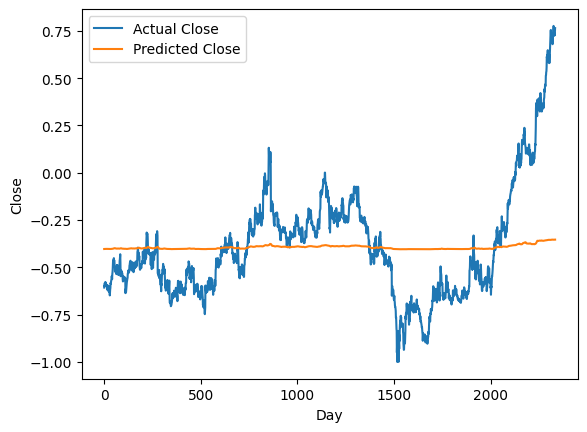

In [60]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [61]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([250.2135802 , 250.20824035, 250.21743989, ..., 258.77140776,
       258.76434621, 258.74952929])

In [62]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([215.06666856, 216.9666572 , 216.30000372, ..., 445.10000733,
       449.35000165, 451.60000469])

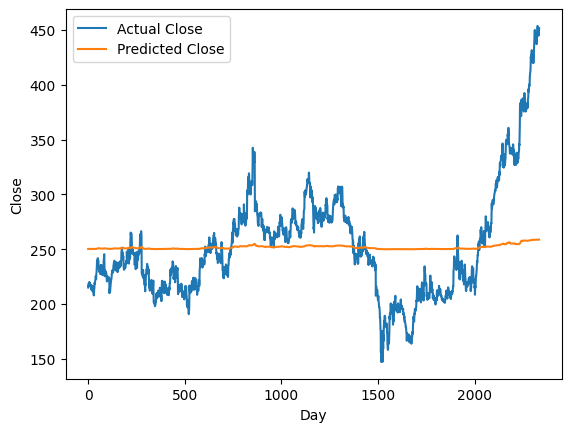

In [63]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [68]:
with torch.no_grad():
  test_predictions = model(X_test.to(device)).to('cpu').numpy()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([258.73333501, 258.72939308, 258.72526613, 258.73295983,
       258.74729879, 258.77585335, 258.8087353 , 258.84598061,
       258.8646675 , 258.87309099, 258.86355739, 258.8540135 ,
       258.86099796, 258.87075256, 258.86956022, 258.870105  ,
       258.87161084, 258.87530608, 258.88878161, 258.90995599,
       258.91813279, 258.89025663, 258.85184981, 258.84566196,
       258.85568381, 258.84424862, 258.84473687, 258.83232005,
       258.81721532, 258.79723844, 258.78520708, 258.78105957,
       258.78057133, 258.77975416, 258.77658315, 258.75391835,
       258.74626062, 258.73868513, 258.72294312, 258.71170323,
       258.73433719, 258.75838963, 258.76371406, 258.74570043,
       258.72643792, 258.70155289, 258.69610512, 258.69526226,
       258.69555006, 258.68821612, 258.69271825, 258.70260647,
       258.72372431, 258.72838576, 258.72435132, 258.73245103,
       258.75381042, 258.76386824, 258.76084627, 258.75319369,
       258.75684781, 258.75994687, 258.74434362, 258.72

In [69]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([463.24999964, 466.35000976, 475.10001016, 473.89999894,
       468.39999723, 465.8500068 , 473.1499945 , 472.29998742,
       472.00000003, 472.89999302, 472.35000416, 472.50000299,
       478.85000152, 492.1499939 , 490.45001056, 471.35000852,
       462.2999899 , 472.25000151, 465.04998562, 468.45001397,
       465.70000797, 464.79998414, 460.1000036 , 456.04998374,
       454.95001629, 454.89998927, 452.35000913, 458.64999091,
       451.75000352, 448.74999604, 449.2000131 , 450.25000492,
       441.00000156, 441.64999308, 447.79998631, 454.24999776,
       450.45001022, 450.89999643, 443.35000725, 441.3999916 ,
       440.10000857, 442.79998755, 439.70000826, 441.04998747,
       437.50000141, 443.10000577, 447.45001302, 445.89999767,
       442.649999  , 447.20001154, 451.14999791, 453.5000036 ,
       449.95000726, 448.35000601, 452.0499909 , 452.95001473,
       447.49999892, 443.10000577, 442.60000281, 442.45001426,
       449.14999635, 440.75000008, 444.3999888 , 439.75

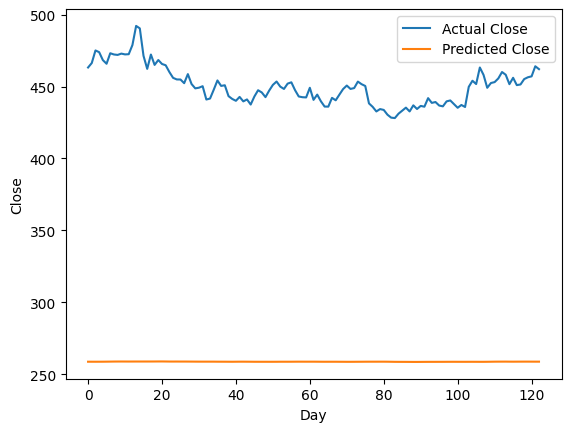

In [70]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [67]:
#